In [1]:
import numpy as np
import os
import pandas as pd
import xarray as xr
import rioxarray
from matplotlib import pyplot as plt
import seaborn as sns
import codebase
from codebase import volume_pipeline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [3]:
# Selct location
res_name = 'Powell'
grdc_id = 4152050

In [4]:
# Filepaths
grdc_dir = '/global/scratch/users/ann_scheliga/aux_dam_datasets/GRDC_CRB/'
met_dir = '/global/scratch/users/ann_scheliga/era5_test_data/'
res_dir = '/global/scratch/users/ann_scheliga/CYGNSS_daily/'

## Load data

In [5]:
# Load reservoir dataset
res_shp = codebase.load_data.load_GRanD()
res_name_dict = {'Powell':'glen canyon',
                 'Mead': 'hoover',
                 'Mohave': 'davis bor',
                 'Havasu': 'parker'}

In [24]:
# Load subset CYGNSS reservoir data
sw_area = pd.read_csv(res_dir+res_name_dict[res_name]+'_area.csv', index_col = 0)
sw_area.index = pd.to_datetime(sw_area.index)
sw_area = sw_area.loc[sw_area.index < pd.to_datetime('2024-01-01'),'Area m2']

In [7]:
# Load GRDC data
watershed_gpd, grdc_Q = codebase.load_data.load_GRDC_station_data_by_ID(grdc_id,filepath=grdc_dir,timeseries_dict={'start_year':2019,'stop_year':2024})

In [8]:
# Load ERA5 data, subset to GRDC watershed
tempK_files = codebase.utils.grab_matching_names_from_filepath(met_dir,r'daily_tempK')
precip_files = codebase.utils.grab_matching_names_from_filepath(met_dir,r'daily_tot_precip')
type_precip_files = codebase.utils.grab_matching_names_from_filepath(met_dir,r'daily_precip_type')

concat_dict = {'dim':'valid_time'}

tempK_xr = codebase.area_subsets.era5_shape_subset_and_concat(ordered_filenames=tempK_files,
                                                                 filepath=met_dir,
                                                                 concat_dict=concat_dict,
                                                                subset_gpd=watershed_gpd)
precip_xr = codebase.area_subsets.era5_shape_subset_and_concat(ordered_filenames=precip_files,
                                                                 filepath=met_dir,
                                                                 concat_dict=concat_dict,
                                                                subset_gpd=watershed_gpd)
type_precip_xr = codebase.area_subsets.era5_shape_subset_and_concat(ordered_filenames=type_precip_files,
                                                                 filepath=met_dir,
                                                                 concat_dict=concat_dict,
                                                                subset_gpd=watershed_gpd)

Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!


## Calculate inputs

Projected to equal area


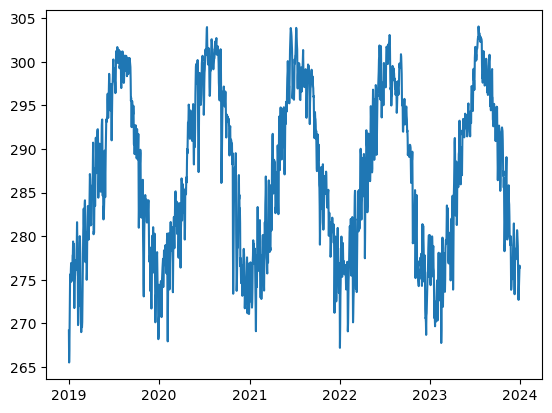

In [55]:
# Areal-average of temperature
tempK_1dim = codebase.area_calcs.CYGNSS_001_areal_average(tempK_xr,x_dim = 'longitude', y_dim = 'latitude',with_index = 'valid_time')
tempK_1dim.rename('Temp K',inplace=True)
plt.plot(tempK_1dim)

Projected to equal area


<Axes: >

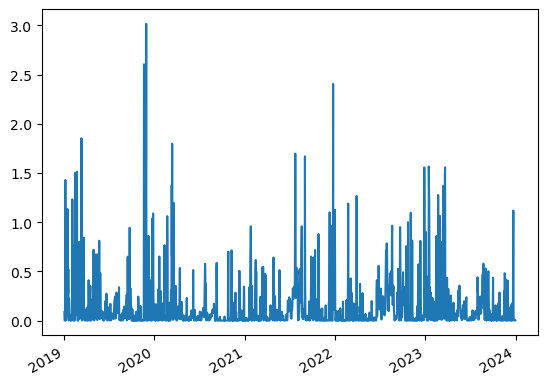

In [57]:
# Areal sum of precip
precip_1dim = codebase.area_calcs.CYGNSS_001_areal_aggregation(np.nansum,precip_xr,x_dim = 'longitude', y_dim = 'latitude',with_index = 'valid_time')
precip_1dim.rename('Precip m',inplace=True)
precip_1dim.plot()

In [66]:
# [troubleshooting] precip data is missing the first day of each year...
nan_dates = pd.date_range(start = precip_1dim.index.min(), end = precip_1dim.index.max(), freq = 'D').difference(precip_1dim.index)

In [75]:
all_data = pd.concat([tempK_1dim, precip_1dim, sw_area, grdc_Q],axis=1)
all_data.interpolate(method='linear',axis=0,inplace=True) # interpolate missing interiror values
all_data.bfill(inplace=True) # backfill missing first value

## Split data

In [77]:
X = all_data.drop(columns=['Q m3s'])
y = all_data['Q m3s']

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

In [80]:
print(f'X train shape: {X_train.shape}; y train shape: {y_train.shape}')
print(f'X test shape: {X_test.shape}; y test shape: {y_test.shape}')

X train shape: (1460, 3); y train shape: (1460,)
X test shape: (366, 3); y test shape: (366,)


In [14]:
from tensorflow.keras import models
from numpy import array_equal
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Input
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import RepeatVector

## Create model structure

## Fit model

In [12]:
model = LinearRegression()
model.fit(area_train,elev_train)

LinearRegression()

## Evaluate model (train/test)

In [13]:
print(f'Training R^2: {model.score(area_train, elev_train)}')
print(f'Test R^2: {model.score(area_test, elev_test)}')

Training R^2: 0.6416045084867384
Test R^2: 0.37122030132552875


In [14]:
elev_train_pred = model.predict(area_train)
elev_test_pred = model.predict(area_test)
elev_pred = model.predict(area)

In [15]:
print(f'Train RMSE: {mean_squared_error(elev_train, elev_train_pred, squared=False)}')
print(f'Test RMSE: {mean_squared_error(elev_test, elev_test_pred, squared=False)}')

Train RMSE: 3.3096551043975353
Test RMSE: 3.6153480167418586


In [16]:
model.coef_ , model.intercept_

(array([[0.08586632]]), array([1128.65335458]))

## Evaluate model to USBR

In [17]:
elev_pred_df = pd.DataFrame(index = area.index, data = elev_pred)
elev_pred_df.head()

,0
2018-08-01,1155.857199
2018-09-01,1154.300352
2018-10-01,1155.283624
2018-11-01,1158.233438
2018-12-01,1158.151499


<Axes: xlabel='Datetime (UTC)'>

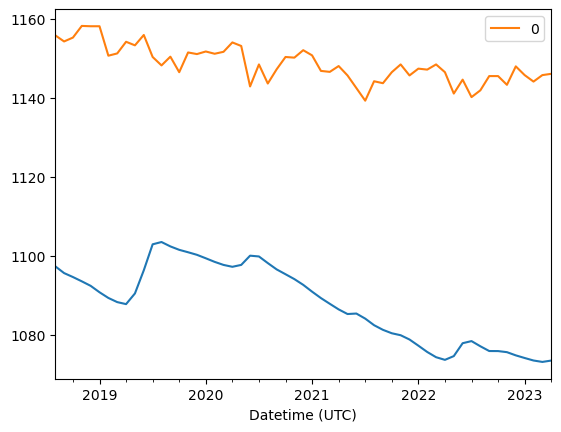

In [18]:
elev_ref_match , elev_pred_match = codebase.time_series_calcs.intersecting_timeframes(elev_ref,elev_pred_df,buffer=0)
ax = elev_ref_match.plot()
elev_pred_match.plot(ax=ax)

In [19]:
print(f'RMSE to USBR: {mean_squared_error(elev_ref_match , elev_pred_match, squared=False)}')

RMSE to USBR: 61.209457471017


## Use model to calculate volume

In [20]:
deltV_ref_m3 = codebase.utils.convert_from_af_to_m3(res_ref['Lake/Reservoir Change In Storage [af]'])

In [21]:
deltV_calc_km2_m = volume_pipeline.calculate_trapezoidal_volume(area=area, elev=elev_pred) # units: km2 * m

In [23]:
deltV_calc_m3 = pd.DataFrame(index=area.index[1:],data=deltV_calc_km2_m) * (10**6) 

In [26]:
print(deltV_calc_m3.cumsum().tail())
deltV_ref_m3.cumsum().tail()

                       0
2022-12-01 -2.131823e+09
2023-01-01 -2.601561e+09
2023-02-01 -2.912764e+09
2023-03-01 -2.601561e+09
2023-04-01 -2.535567e+09


Datetime (UTC)
2023-09-01   -2.151791e+08
2023-10-01   -2.178989e+08
2023-11-01   -2.215708e+08
2023-12-01   -2.290496e+08
2024-01-01   -2.396685e+08
Name: Lake/Reservoir Change In Storage [af], dtype: float64

In [28]:
deltV_ref_match , deltV_calc_match = codebase.time_series_calcs.intersecting_timeframes(deltV_ref_m3 , deltV_calc_m3,buffer=0)

<Axes: xlabel='Datetime (UTC)'>

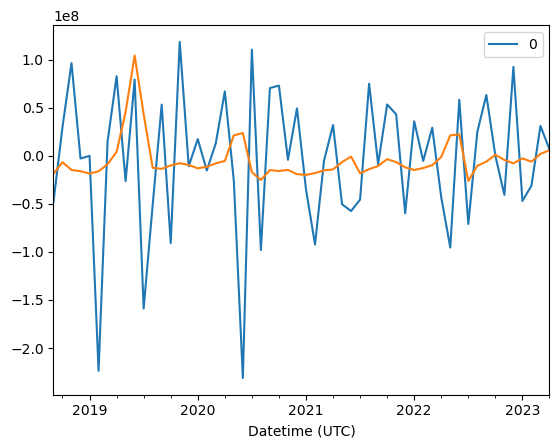

In [31]:
ax = (deltV_calc_match/10).plot()
deltV_ref_match.plot(ax=ax)